### 1.Setup

In [14]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
#tf.logging.set_verbosity(tf.logging.ERROR) 

print("tf version: {}".format(tf.__version__))
tf.set_random_seed(1)
np.random.seed(1)

tf.reset_default_graph()

tf version: 1.14.0


### 2. Get the data

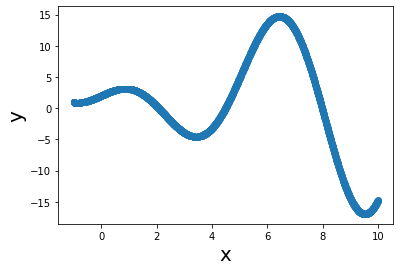

In [15]:
x = np.linspace(-1, 10, 2000)[:, np.newaxis]
noise = np.random.normal(0, 0.01, size=x.shape)
y = np.cos(x)*2*x + 2 

plt.scatter(x,y)
plt.xlabel('x', fontsize = 20)  
plt.ylabel('y', fontsize = 20)
plt.show()

### 3. Build the neural network 

#### 3.1 setup the neural network

In [16]:
input_x = tf.placeholder(tf.float32, [None, 1]) 
output_y = tf.placeholder(tf.float32, [None, 1]) 

with tf.variable_scope("DNN_1_model"):
    h1_a = tf.layers.dense(inputs=input_x, units=10, activation=tf.nn.relu, name='h1_a')
    h2_a = tf.layers.dense(inputs=h1_a, units=10, activation=tf.nn.relu, name='h2_a')
    h3_a = tf.layers.dense(inputs=h2_a, units=10, activation=tf.nn.relu, name='h3_a') 
    output_a = tf.layers.dense(inputs=h3_a, units=1, name='output_a')


    
    
trainable_variable_a = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "DNN_1_model")

loss_a = tf.losses.mean_squared_error(output_y, output_a)

optimizer_a = tf.train.AdamOptimizer(learning_rate=1e-4)

optimizer_g = tf.train.GradientDescentOptimizer(learning_rate=0.00005)

train_op_a = optimizer_a.minimize(loss_a, var_list= trainable_variable_a)





grads = tf.gradients(loss_a, trainable_variable_a)



#### 3.2 play with the parameters

In [17]:
    def flatten_list_square(tensor_list):
        return tf.concat([flatten(t)**2 for t in tensor_list], axis=0)
    
    def flatten_list(tensor_list):
        return tf.concat([flatten(t) for t in tensor_list], axis=0)

    def flatten(tensor):
        return tf.reshape(tensor, shape=(-1,))

In [18]:
def get_weights_variable(layer_name):
    
    with tf.variable_scope(layer_name, reuse=True):
        variable = tf.get_variable('kernel')

    return variable

weights_whole = []

weights_h1a = get_weights_variable(layer_name='DNN_1_model/h1_a')
weights_whole.append(weights_h1a)
weights_h2a = get_weights_variable(layer_name='DNN_1_model/h2_a')
weights_whole.append(weights_h2a)
weights_h3a = get_weights_variable(layer_name='DNN_1_model/h3_a')
weights_whole.append(weights_h3a)


#print(weights_h2a)


flatten_weights = flatten_list(trainable_variable_a)

hessians_weights_h1a = tf.hessians(loss_a,weights_h1a)[0]
hessians_weights_h2a = tf.hessians(loss_a,weights_h2a)[0]
hessians_weights_h3a = tf.hessians(loss_a,weights_h3a)[0]

hessians = [hessians_weights_h1a, hessians_weights_h2a, hessians_weights_h3a]


flatten_grads = tf.sqrt(tf.reduce_sum(flatten_list_square(grads)))



In [19]:
train_op_g = optimizer_a.minimize(0.000001*flatten_grads, var_list= trainable_variable_a)

In [20]:
def list_tensor_pow(t1):
    return tf.concat([t**2 for t in t1], axis=0)

In [21]:
def get_total_para_num(tf_variables):
    total_parameters = 0
    for variable in tf_variables:
        shape = variable.get_shape()
        variable_parameters = 1
        for dim in shape:
            variable_parameters *= dim.value
        total_parameters += variable_parameters
    return total_parameters

print(get_total_para_num(trainable_variable_a))
print(get_total_para_num(weights_whole))


251
210


In [22]:
def flatten_vector_tf(vector):
    vector_flatten = []
    for i in range(len(vector)):
        print(len(vector))
        x = vector[i]
        print(x)
        vector_flatten.extend(x)
    return vector_flatten

In [23]:
def flatten_vector(vector):
    vector_flatten = []
    for i in range(len(vector)):
        x = np.array(vector[i]).flatten()
        vector_flatten.extend(x)
    return np.array(vector_flatten)

#### 3.3 train the network

In [24]:
from numpy import linalg as LA

   
train_batch_size = 64

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer()) 

    list_loss_a = []
    
    list_iter = []
    
    list_weights = []
    
    list_grads = []
    
    list_minimal_ratio = []
    
    
    for iteration in range(30000):
            
        feed_dict_train = {input_x: x, output_y: y}
            
        if iteration % 100 == 0:
            list_loss_a.append(sess.run(loss_a, feed_dict = feed_dict_train))
            list_iter.append(iteration)
            #grads_a = flatten_vector(sess.run(grads, feed_dict = feed_dict_train))
            gradient_norm = sess.run(flatten_grads, feed_dict = feed_dict_train)
            hessians_a = sess.run(hessians, feed_dict = feed_dict_train)
            
            list_e_value = []
            for hessians_b  in hessians_a:
                corrected_shape = (np.shape(hessians_b)[0]*np.shape(hessians_b)[1], 
                np.shape(hessians_b)[2]* np.shape(hessians_b)[3])
                v1, _ = LA.eig(np.reshape(hessians_b, corrected_shape))
                list_e_value.extend(flatten_vector(v1))      
            list_minimal_ratio.append(len(np.argwhere(np.array(list_e_value)==0))/210)
            #print(np.shape(list_e_value))
            weights = flatten_vector(sess.run(weights_whole))
        

            list_grads.append(gradient_norm)
            list_weights.append(weights)
            
        sess.run(train_op_a, feed_dict = feed_dict_train)
            
    for iteration in range(30000,35000, 1):
        
        feed_dict_train = {input_x: x, output_y: y}
            
        if iteration % 100 == 0:
            list_loss_a.append(sess.run(loss_a, feed_dict = feed_dict_train))
            list_iter.append(iteration)
            #grads_a = flatten_vector(sess.run(grads, feed_dict = feed_dict_train))
            gradient_norm = sess.run(flatten_grads, feed_dict = feed_dict_train)
            weights = flatten_vector(sess.run(weights_whole))

            #print(flatten_grads_a)
            #gradient_norm = np.sqrt(np.sum(grads_a**2))
            #print(gradient_norm)
            list_grads.append(gradient_norm)
            list_weights.append(weights)
            
        sess.run(train_op_g, feed_dict = feed_dict_train)
        
            
                
        
        
    pred_a = sess.run(output_a, feed_dict = feed_dict_train)
    
          
        
        

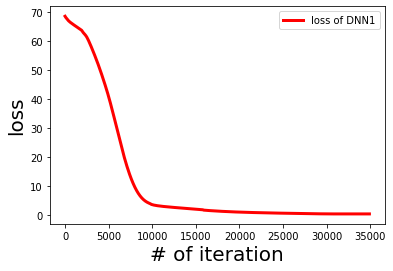

In [25]:
plt.plot(list_iter,list_loss_a, 'r-', lw=3, label = "loss of DNN1")
plt.xlabel("# of iteration", fontsize = 20)
plt.ylabel("loss", fontsize = 20)
plt.legend()
plt.show()
            

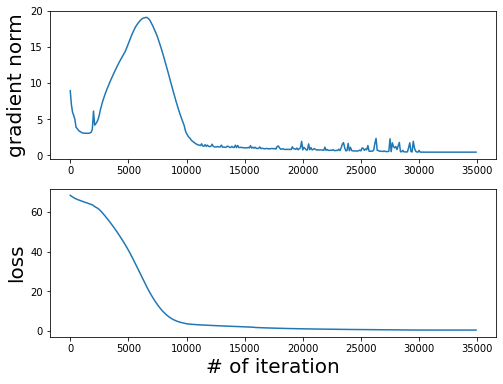

0.42159602
0.3905593


In [26]:
fig, axs = plt.subplots(2)
#fig.suptitle('Vertically stacked subplots')
fig.set_size_inches(8, 6)
axs[0].plot(list_iter, list_grads)
axs[1].plot(list_iter,list_loss_a)
axs[1].set_xlabel("# of iteration",  fontsize = 20)
axs[1].set_ylabel("loss",  fontsize = 20)
axs[0].set_ylabel("gradient norm",  fontsize = 20)

plt.show()


index_1 = np.argmin(list_grads)
print(list_grads[index_1])

print(list_loss_a[index_1])
#print(list_minimal_ratio[index_1])



#print(list_weights[index_1])


## run 100 times to find the loss and minimal ratio

In [30]:
def get_the_minimial_ratio_and_loss(sess):
    
    sess.run(tf.global_variables_initializer())
    list_loss_a = []
    
    list_iter = []
    
    list_weights = []
    
    list_grads = []
    
    list_minimal_ratio = []
    
    
    for iteration in range(30000):
            
        feed_dict_train = {input_x: x, output_y: y}
            
        if iteration % 100 == 0:
            list_loss_a.append(sess.run(loss_a, feed_dict = feed_dict_train))
            list_iter.append(iteration)
            
            gradient_norm = sess.run(flatten_grads, feed_dict = feed_dict_train)
            hessians_a = sess.run(hessians, feed_dict = feed_dict_train)
            
            list_e_value = []
            for hessians_b  in hessians_a:
                corrected_shape = (np.shape(hessians_b)[0]*np.shape(hessians_b)[1], 
                np.shape(hessians_b)[2]* np.shape(hessians_b)[3])
                v1, _ = LA.eig(np.reshape(hessians_b, corrected_shape))
                list_e_value.extend(flatten_vector(v1))      
            list_minimal_ratio.append(len(np.argwhere(np.array(list_e_value)==0))/210)

            weights = flatten_vector(sess.run(weights_whole))
            list_grads.append(gradient_norm)
            list_weights.append(weights)
            
        sess.run(train_op_a, feed_dict = feed_dict_train)
        
        
    for iteration in range(30000,35000, 1):
        
        feed_dict_train = {input_x: x, output_y: y}
            
        if iteration % 100 == 0:
            list_loss_a.append(sess.run(loss_a, feed_dict = feed_dict_train))
            list_iter.append(iteration)
            #grads_a = flatten_vector(sess.run(grads, feed_dict = feed_dict_train))
            gradient_norm = sess.run(flatten_grads, feed_dict = feed_dict_train)
            
            hessians_a = sess.run(hessians, feed_dict = feed_dict_train)
            
            list_e_value = []
            for hessians_b  in hessians_a:
                corrected_shape = (np.shape(hessians_b)[0]*np.shape(hessians_b)[1], 
                np.shape(hessians_b)[2]* np.shape(hessians_b)[3])
                v1, _ = LA.eig(np.reshape(hessians_b, corrected_shape))
                list_e_value.extend(flatten_vector(v1))      
            list_minimal_ratio.append(len(np.argwhere(np.array(list_e_value)==0))/210)
            
            
            
            weights = flatten_vector(sess.run(weights_whole))

            #print(flatten_grads_a)
            #gradient_norm = np.sqrt(np.sum(grads_a**2))
            #print(gradient_norm)
            list_grads.append(gradient_norm)
            list_weights.append(weights)
            
        sess.run(train_op_g, feed_dict = feed_dict_train)
        
            
    index_1 = np.argmin(list_grads[200:])+200
            
    return [list_grads[index_1], list_loss_a[index_1],list_minimal_ratio[index_1]]


In [31]:
data_list=[]
with tf.Session() as sess1:
    for i in range(100):
        print(i)
        data_list.append(get_the_minimial_ratio_and_loss(sess1))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [32]:
print(np.shape(data_list))
print(np.array(data_list)[:,1])

(100, 3)
[1.73772001e+00 5.08047462e-01 6.65718913e-02 4.54813153e-01
 7.87138846e-03 3.11730765e-02 1.48254940e-02 3.94904733e-01
 5.46486415e-02 2.17206001e+00 1.76300704e+00 5.30082583e-02
 1.74297976e+00 1.73706591e+00 3.60825121e-01 2.06346326e-02
 5.48615269e-02 4.71940011e-01 2.80972179e-02 2.13532709e-02
 3.87961537e-01 6.74804568e-01 4.43362862e-01 2.18770709e-02
 2.21512113e-02 1.73797989e+00 5.25886659e-03 3.47303003e-02
 1.74483955e-02 6.35475144e-02 8.63395259e-02 1.73738718e+00
 1.73808670e+00 1.21722734e-02 8.63748323e-03 2.23088288e+00
 1.94781837e+01 8.61845911e-03 4.02504727e-02 6.05225489e-02
 2.24777246e+00 1.12852724e-02 5.33128120e-02 2.22579297e-02
 3.83889586e-01 1.82943707e+01 3.38678807e-02 3.59120220e-01
 2.04578762e+01 4.19106811e-01 3.57616879e-02 5.35082892e-02
 2.65334081e-02 3.94581854e-02 2.72750111e+01 1.95082741e+01
 8.73942394e-03 2.39767842e-02 5.74833006e-02 5.45649044e-03
 5.21865189e-02 3.28175933e-03 2.20434964e-02 3.48907895e-03
 4.90699634e-02

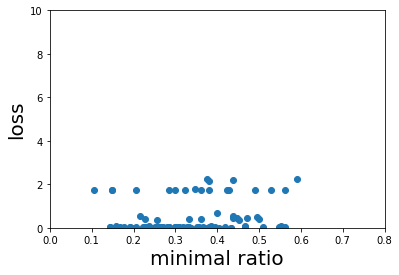

In [35]:
plt.scatter(np.array(data_list)[:,2],np.array(data_list)[:,1])
plt.xlim([0,0.8])
plt.ylim([0,10])
plt.xlabel("minimal ratio", fontsize = 20)
plt.ylabel("loss", fontsize = 20)
plt.show()

In [71]:
x1 = [7,8, 6, 5, 4]

index=np.argmax(x1[2:])
print(index)

0
